**Задание**

На вебинаре мы говорили что долгое время CNN и RNN архитектуры были конурируещими выяснить какая архитектура больше подходит для задачи сантимент анализа на данных с вебинара 

1. построить свёрточные архитектуры 
   
2. построить различные архитектуры с RNN
   
3. построить совместные архитектуры CNN -> RNN  и (RNN -> CNN)
   
4. сдлать выводы что получилось лучше

In [1]:
# попробуем запрограммировать простую рекурентную сеть. Возьмем датасет с прошлого занятия

import pandas as pd
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

df_train = pd.read_csv("lection8/data/train.csv")
df_test = pd.read_csv("lection8/data/test.csv")
df_val = pd.read_csv("lection8/data/val.csv")

In [2]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [3]:
df_train['class'].value_counts()

1    92063
0    89404
Name: class, dtype: int64

In [4]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

<BarContainer object of 192 artists>

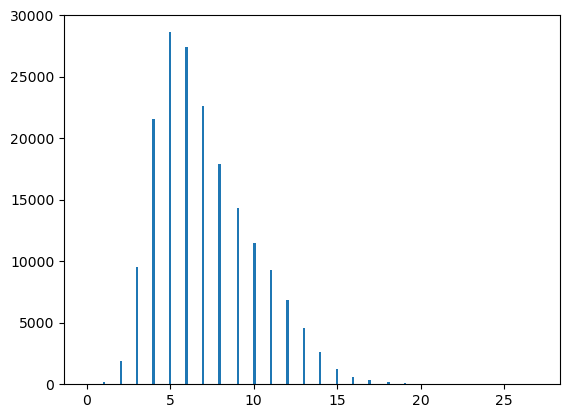

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

_, _, hist = plt.hist(df_train['text'].apply(lambda text: len(text.split())), bins='auto')
hist

In [6]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input, Embedding, Conv1D, GlobalMaxPool1D, Bidirectional, SimpleRNN, LSTM, GRU, Masking
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.callbacks import TensorBoard 
from keras.metrics import categorical_crossentropy
from keras.callbacks import EarlyStopping  

In [7]:
text_corpus_train = df_train['text'].values
text_corpus_valid = df_val['text'].values
text_corpus_test = df_test['text'].values

In [8]:
tokenizer = Tokenizer(num_words=None, 
                     filters='#$%&()*+-<=>@[\\]^_`{|}~\t\n',
                     lower = False, split = ' ')
tokenizer.fit_on_texts(text_corpus_train)

sequences_train = tokenizer.texts_to_sequences(text_corpus_train)
sequences_val = tokenizer.texts_to_sequences(text_corpus_valid)
sequences_test = tokenizer.texts_to_sequences(text_corpus_test)

word_count = len(tokenizer.index_word) + 1
training_length = max([len(i.split()) for i in text_corpus_train])

X_train = pad_sequences(sequences_train, maxlen=training_length)
X_valid = pad_sequences(sequences_val, maxlen=training_length)

In [9]:
y_train = df_train['class'].values
y_val = df_val['class'].values

In [14]:
# Используем RNN

In [12]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
# model.add(Masking(mask_value=0.0))

model.add(SimpleRNN(units=64, return_sequences=True))
model.add(SimpleRNN(units=64, return_sequences=True))
model.add(SimpleRNN(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping]
                    )

Epoch 1/10
319/319 [==============================] - 33s 100ms/step - loss: 0.5609 - accuracy: 0.6962 - val_loss: 0.4913 - val_accuracy: 0.7566
Epoch 2/10
319/319 [==============================] - 33s 103ms/step - loss: 0.2891 - accuracy: 0.8793 - val_loss: 0.5608 - val_accuracy: 0.7444


In [15]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 1s 23ms/step - loss: 0.5904 - accuracy: 0.7346


Test score: 0.5903974771499634
Test accuracy: 0.7345589399337769


In [16]:
results = []

results.append(['RNN', score[0], score[1]])

In [ ]:
# Используем LSTM

In [17]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
# model.add(Masking(mask_value=0.0))

model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 80s 237ms/step - loss: 0.5516 - accuracy: 0.7053 - val_loss: 0.4869 - val_accuracy: 0.7573
Epoch 2/10
319/319 [==============================] - 72s 227ms/step - loss: 0.3043 - accuracy: 0.8729 - val_loss: 0.5385 - val_accuracy: 0.7481


In [18]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 3s 65ms/step - loss: 0.5840 - accuracy: 0.7351


Test score: 0.5840451717376709
Test accuracy: 0.7350879311561584


In [19]:
results.append(['LSTM', score[0], score[1]])

In [ ]:
# Используем GRU

In [20]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
# model.add(Masking(mask_value=0.0))

model.add(GRU(units=64, return_sequences=True))
model.add(GRU(units=64, return_sequences=True))
model.add(GRU(64))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 60s 177ms/step - loss: 0.5426 - accuracy: 0.7136 - val_loss: 0.4882 - val_accuracy: 0.7596
Epoch 2/10
319/319 [==============================] - 55s 171ms/step - loss: 0.2932 - accuracy: 0.8784 - val_loss: 0.5515 - val_accuracy: 0.7421


In [21]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 2s 54ms/step - loss: 0.6014 - accuracy: 0.7342


Test score: 0.6013953685760498
Test accuracy: 0.7341621518135071


In [22]:
results.append(['GRU', score[0], score[1]])

In [ ]:
# Используем CNN

In [23]:
model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
# model.add(Masking(mask_value=0.0))

model.add(Conv1D(128, 3))
model.add(Conv1D(128, 3))
model.add(Conv1D(128, 3))
model.add(Activation("relu"))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 18s 56ms/step - loss: 0.5460 - accuracy: 0.7098 - val_loss: 0.4952 - val_accuracy: 0.7490
Epoch 2/10
319/319 [==============================] - 19s 59ms/step - loss: 0.2907 - accuracy: 0.8787 - val_loss: 0.5474 - val_accuracy: 0.7465


In [24]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 1s 14ms/step - loss: 0.5960 - accuracy: 0.7345


Test score: 0.5960040092468262
Test accuracy: 0.7344707250595093


In [25]:
results.append(['CNN', score[0], score[1]])

In [26]:
# Используем RNN + CNN

In [27]:
model = Sequential()

model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
# model.add(Masking(mask_value=0.0))

model.add(SimpleRNN(units=64, return_sequences=True))
model.add(SimpleRNN(units=64, return_sequences=True))
model.add(SimpleRNN(units=64, return_sequences=True))

model.add(Conv1D(64, 3, activation="relu"))
model.add(Conv1D(64, 3, activation="relu"))
model.add(Conv1D(64, 3, activation="relu"))
model.add(GlobalMaxPool1D())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))



model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 41s 125ms/step - loss: 0.5586 - accuracy: 0.7000 - val_loss: 0.4902 - val_accuracy: 0.7558
Epoch 2/10
319/319 [==============================] - 40s 125ms/step - loss: 0.3044 - accuracy: 0.8724 - val_loss: 0.5790 - val_accuracy: 0.7427


In [28]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 1s 31ms/step - loss: 0.6023 - accuracy: 0.7373


Test score: 0.6022745966911316
Test accuracy: 0.7373363375663757


In [29]:
results.append(['RNN+CNN', score[0], score[1]])

In [30]:
# Используем LSTM + CNN

In [31]:
model = Sequential()

model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
# model.add(Masking(mask_value=0.0))

model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=64, return_sequences=True))
model.add(LSTM(units=64, return_sequences=True))

model.add(Conv1D(64, 3, activation="relu"))
model.add(Conv1D(64, 3, activation="relu"))
model.add(Conv1D(64, 3, activation="relu"))
model.add(GlobalMaxPool1D())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))



model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 91s 270ms/step - loss: 0.5619 - accuracy: 0.6962 - val_loss: 0.4871 - val_accuracy: 0.7575
Epoch 2/10
319/319 [==============================] - 87s 272ms/step - loss: 0.3171 - accuracy: 0.8665 - val_loss: 0.5541 - val_accuracy: 0.7426


In [32]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 4s 82ms/step - loss: 0.5850 - accuracy: 0.7378


Test score: 0.5849885940551758
Test accuracy: 0.7377771735191345


In [33]:
results.append(['LSTM+CNN', score[0], score[1]])

In [ ]:
# Используем GRU + CNN

In [34]:
model = Sequential()

model = Sequential()

model.add(
    Embedding(input_dim=word_count,
              input_length=training_length,
              output_dim=30,
              trainable=True,
              mask_zero=True))
# model.add(Masking(mask_value=0.0))

model.add(GRU(units=64, return_sequences=True))
model.add(GRU(units=64, return_sequences=True))
model.add(GRU(units=64, return_sequences=True))

model.add(Conv1D(64, 3, activation="relu"))
model.add(Conv1D(64, 3, activation="relu"))
model.add(Conv1D(64, 3, activation="relu"))
model.add(GlobalMaxPool1D())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))



model.compile(
    optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


early_stopping=EarlyStopping(monitor='val_loss')  


history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=10,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Epoch 1/10
319/319 [==============================] - 71s 209ms/step - loss: 0.5571 - accuracy: 0.6985 - val_loss: 0.4893 - val_accuracy: 0.7594
Epoch 2/10
319/319 [==============================] - 65s 204ms/step - loss: 0.3176 - accuracy: 0.8668 - val_loss: 0.5434 - val_accuracy: 0.7439


In [35]:
score = model.evaluate(X_valid, y_val, batch_size=512, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

45/45 [==============================] - 3s 56ms/step - loss: 0.5725 - accuracy: 0.7386


Test score: 0.572496771812439
Test accuracy: 0.7386147975921631


In [36]:
results.append(['GRU+CNN', score[0], score[1]])

In [37]:
results_df = pd.DataFrame(results, columns=['model', 'Test score', 'Test_accuracy']).sort_values(by = 'Test_accuracy', ascending = False)
results_df

,model,Test score,Test_accuracy
6,GRU+CNN,0.572497,0.738615
5,LSTM+CNN,0.584989,0.737777
4,RNN+CNN,0.602275,0.737336
1,LSTM,0.584045,0.735088
0,RNN,0.590397,0.734559
3,CNN,0.596004,0.734471
2,GRU,0.601395,0.734162


Все архитектуры показали очень схожие результаты, однако наилучший результат показала соединение GRU+CNN